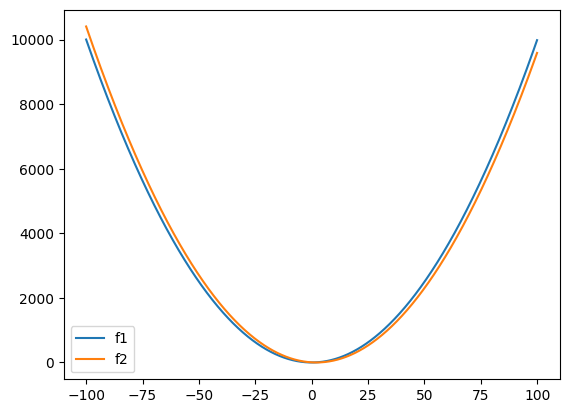

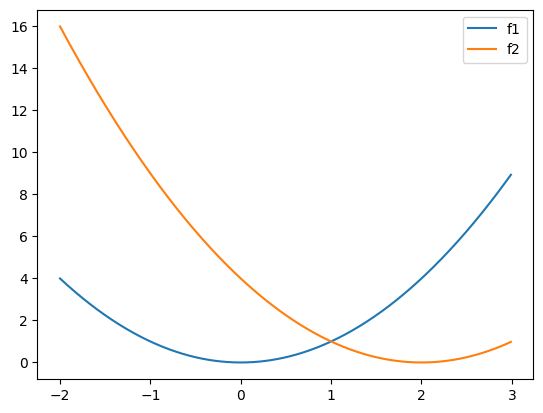

In [20]:
# Problem description
from matplotlib import pyplot as plt
import numpy as np

bounds = [(-100, 100)]

def objf(x):
    return [[xi[0]**2, (xi[0]-2)**2] for xi in x]

x = np.arange(-100, 100, 0.1)
fx = objf([[xi] for xi in x])
f1x = [f[0] for f in fx]
f2x = [f[1] for f in fx]
plt.plot(x, f1x, label='f1')
plt.plot(x, f2x, label='f2')
plt.legend()
plt.show()

x = np.arange(-2, 3, 0.01)
fx = objf([[xi] for xi in x])
f1x = [f[0] for f in fx]
f2x = [f[1] for f in fx]
plt.plot(x, f1x, label='f1')
plt.plot(x, f2x, label='f2')
plt.legend()
plt.show()

In [2]:
from blackboxopt.rbf import RbfModel
from blackboxopt.acquisition import UniformAcquisition, CoordinatePerturbation
from blackboxopt.sampling import NormalSampler

maxeval = 100
ncand = 500
sigma = 0.02
reltol = 0.05
tol = 0.001 * (bounds[0][1] - bounds[0][0])

localAcquisition = CoordinatePerturbation(maxeval, NormalSampler(ncand,sigma), weightpattern=(0.95,), reltol=reltol)
globalAcquisition = UniformAcquisition(ncand, 0.95, tol)

In [3]:
from blackboxopt.optimize import socemo

surrogateModels = [RbfModel(), RbfModel()]
res = socemo(objf, bounds, maxeval, surrogateModels=surrogateModels, acquisitionFunc=localAcquisition, acquisitionFuncGlobal=globalAcquisition, disp=True)

Iteration: 0
fEvals: 4
Time to update surrogate model: 0.000340 s
Fill gaps in the Pareto front: 0.000003 s
Random perturbation of the currently nondominated points: 0.001027 s
Minimum point sampling: 0.000001 s
Uniform random points and scoring: 0.000295 s
Solving the surrogate multiobjective problem: 1.664827 s
Number of new samples:  3
Iteration: 1
fEvals: 7
Time to update surrogate model: 0.000456 s
Fill gaps in the Pareto front: 0.000000 s
Random perturbation of the currently nondominated points: 0.000351 s
Minimum point sampling: 0.000000 s
Uniform random points and scoring: 0.000245 s
Solving the surrogate multiobjective problem: 1.119769 s
Number of new samples:  4
Iteration: 2
fEvals: 11
Time to update surrogate model: 0.000272 s
Fill gaps in the Pareto front: 0.000000 s
Random perturbation of the currently nondominated points: 0.000664 s
Minimum point sampling: 0.000000 s
Uniform random points and scoring: 0.000309 s
Solving the surrogate multiobjective problem: 1.187334 s
Nu

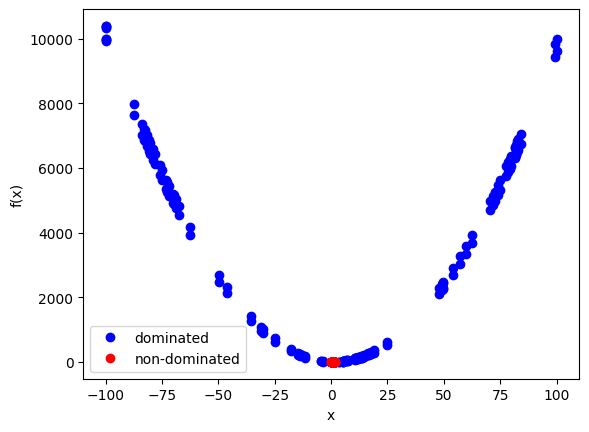

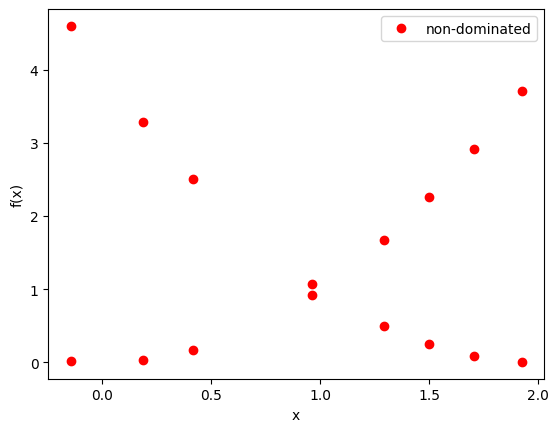

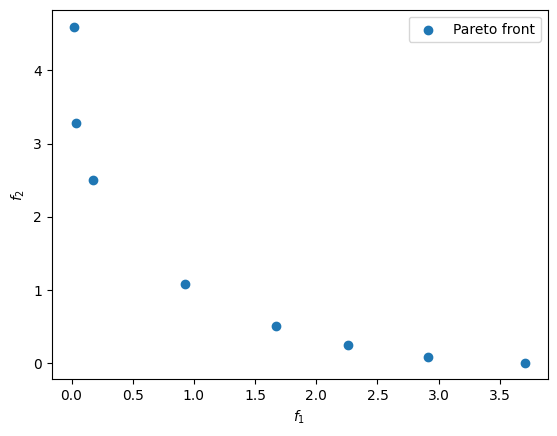

In [21]:
from matplotlib import pyplot as plt

samples = res.samples.flatten()
f1 = res.fsamples[:,0].flatten()
f2 = res.fsamples[:,1].flatten()
nondominated = res.x
paretoFront = res.fx

plt.plot(samples, f1, 'bo', label="dominated")
plt.plot(samples, f2, 'bo')
plt.plot(nondominated, paretoFront[:,0], 'ro', label="non-dominated")
plt.plot(nondominated, paretoFront[:,1], 'ro')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

plt.plot(nondominated, paretoFront[:,0], 'ro', label="non-dominated")
plt.plot(nondominated, paretoFront[:,1], 'ro')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

# plt.scatter(res.fsamples[:, 0], res.fsamples[:, 1], label="Samples")
plt.scatter(res.fx[:, 0], res.fx[:, 1], label="Pareto front")
plt.xlabel(r"$f_1$")
plt.ylabel(r"$f_2$")
plt.legend()
plt.show()

In [7]:
res.fx

array([[1.67002432, 0.50084749],
       [0.17453556, 2.50343743],
       [0.02096023, 4.6000662 ],
       [0.92738048, 1.07535664],
       [2.91491708, 0.08566578],
       [0.03571947, 3.27973568],
       [2.25638084, 0.24787908],
       [3.70530571, 0.00563745]])